In [ ]:
"""
notebook: 1.0.-leibold-data-modeling_shapValueAnalysis.jpynb

author: Christian Leibold

created/updated at: 2025-12-04

intention: SHAP analysis on fitted model. 

content:
---------
-> reads in data, fitted pipeline and fitted model to get ready to evaluate SHAP values fast. 
-> create summary_plot based on OLD SHAP api
-> create different plot based on NEW SHAP api 

"""

In [28]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')


# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time


In [29]:
# 1. loading fitted objects
# ----------------------------------------------
# load data -> CAUTION: you need to place the concat file in a local folder and adjust the path accordingly
df = load(r'..\..\..\temp_data\1.2-leibold-data-preprocessing_concat.joblib')

# load fitted pipeline
preprocessing_pipeline = load("../../models//pipeline_rf_over_under_2019_2023.pkl")

# load fitted model
model = load("../../models/model_rf_over_under_2019_2023.joblib")


# 2. Separate features and target
# ----------------------------------------------
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target


# 3. Stratified subsample for SHAP explanation
# ----------------------------------------------
# train_size can also be much higher when using approximate=True in SHAP explainer
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

# Transform subsample with pipeline
X_sub_clean = preprocessing_pipeline.transform(X_sub)


ℹ️ AggrLocaSplit -> Aggregated from 10000 rows to 9989 groups.


In [30]:
# create OLD SHAP api shap_values object (TreeExplainer)
# ----------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sub_clean, approximate=True)

feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)



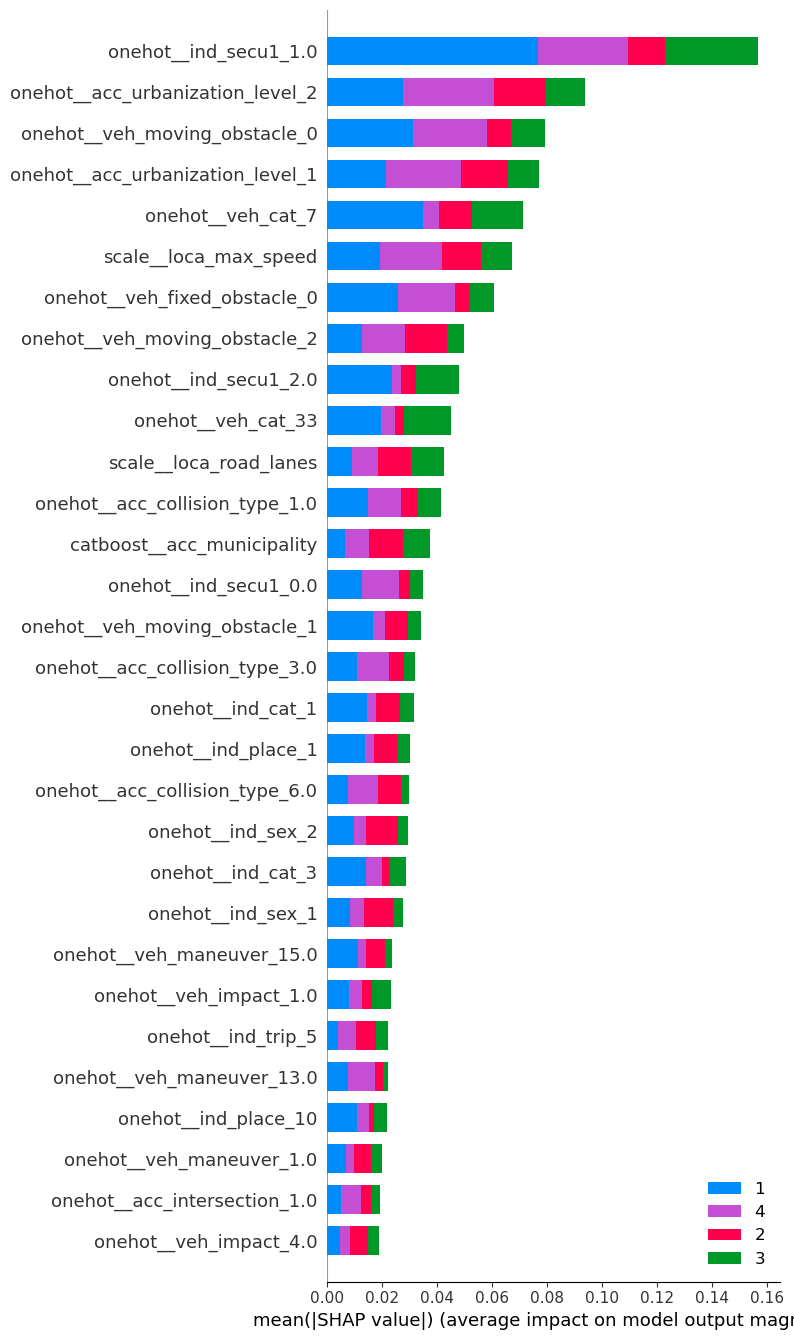

In [31]:
# OLD SHAP summary plot over all classes
# ----------------------------------------------
shap.summary_plot(shap_values, X_sub_df, plot_type="bar", class_names=model.classes_ , title="Top 50 Features Random Forest Model", max_display=30)


In [35]:
# NEW SHAP values -> whatch out: explainer object different from TreeExplainer!!
# ----------------------------
# Explainer object of new SHAP api
explainer = shap.Explainer(model)

# SHAP values with DATAFRAME as input (important to retain feature names)
shap_values = explainer(X_sub_df, approximate=True)


In [36]:
# check shape of new Explainer model 
# ----------------------------
# the order of shape objects matters!
# in most online code examples the order is: n_samples, n_classes, n_features
# here it is: n_samples, n_features, n_classes (I do not know why yet. but keep it so and the plots work)

# if necessary the order can be changed like this (do not do it by default, only if you get errors during plotting)
"""
shap_values = shap.Explanation(
    values=shap_values.values.transpose(0, 2, 1),
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=shap_values.feature_names
)
"""
print(shap_values.shape)          

(9989, 123, 4)


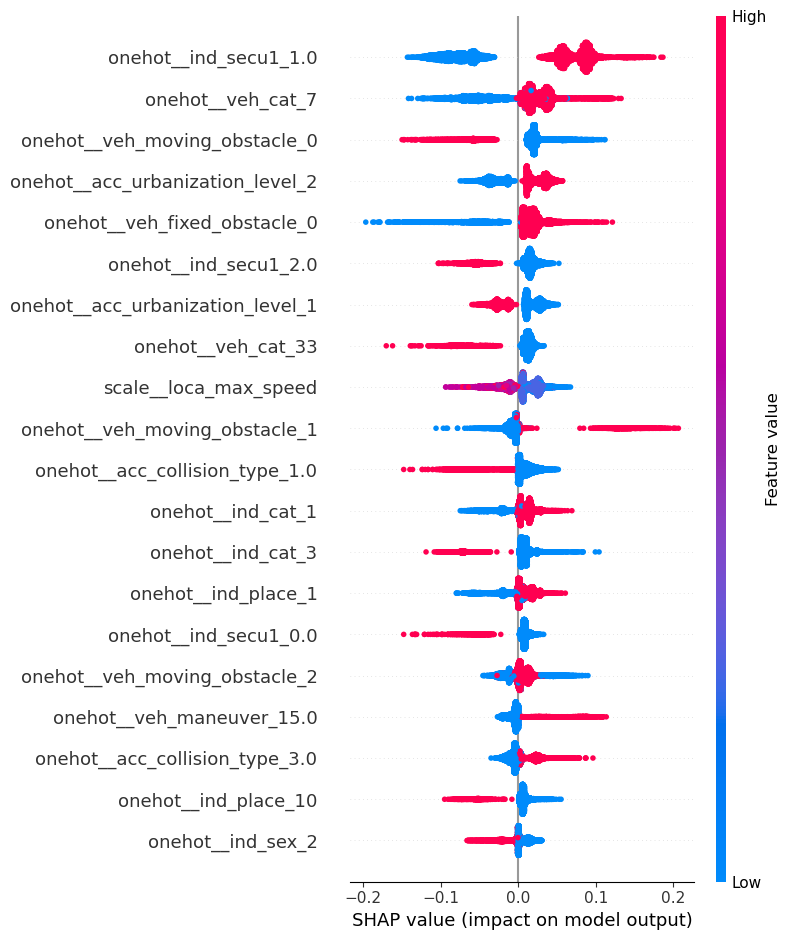

In [37]:
# NEW summary_plot per class
#--------------------------------------------------------------
shap.summary_plot(shap_values.values[:, :, 0], features=X_sub_df, feature_names=shap_values.feature_names)


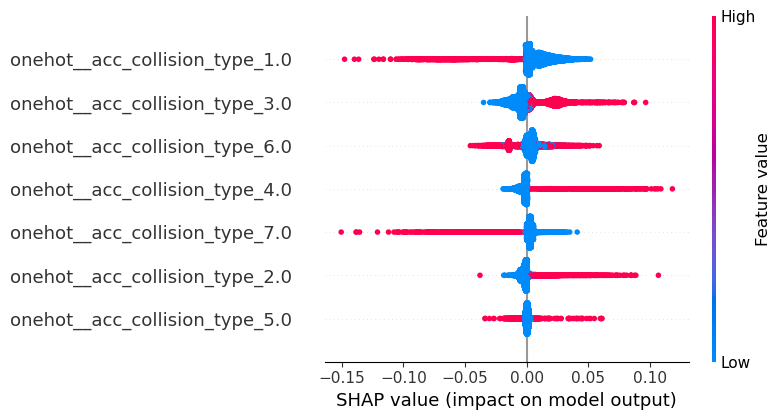

In [38]:
# NEW summary_plot only for subset of features
#--------------------------------------------------------------
# Get all feature names
all_features = shap_values.feature_names

# Filter names that start with the prefix
#prefix = "onehot__ind_secu1_"
prefix = "onehot__acc_collision_type_"
selected_features = [f for f in all_features if f.startswith(prefix)]

# Get indices of the selected features
selected_idx = [all_features.index(f) for f in selected_features]

# Slice SHAP values for class 0 and only those features
shap_subset = shap_values.values[:, selected_idx, 0]

X_subset = X_sub_df[selected_features]

shap.summary_plot(
    shap_subset,
    features=X_subset,
    feature_names=selected_features
)


Summary plot for class 0


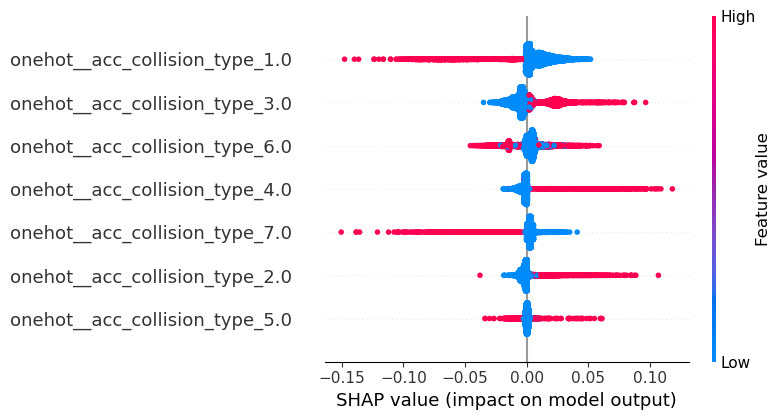

Summary plot for class 1


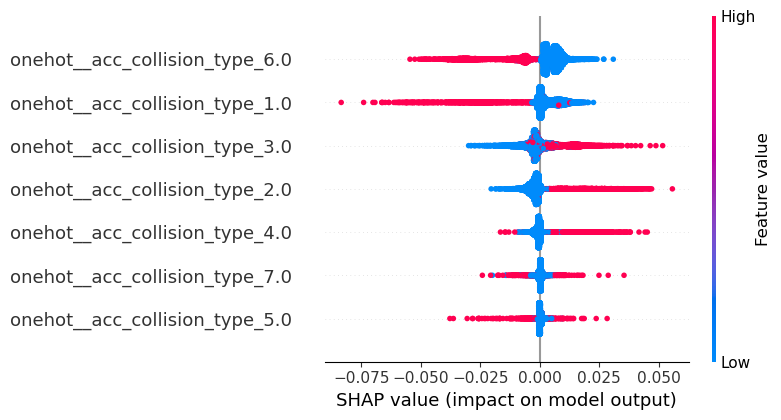

Summary plot for class 2


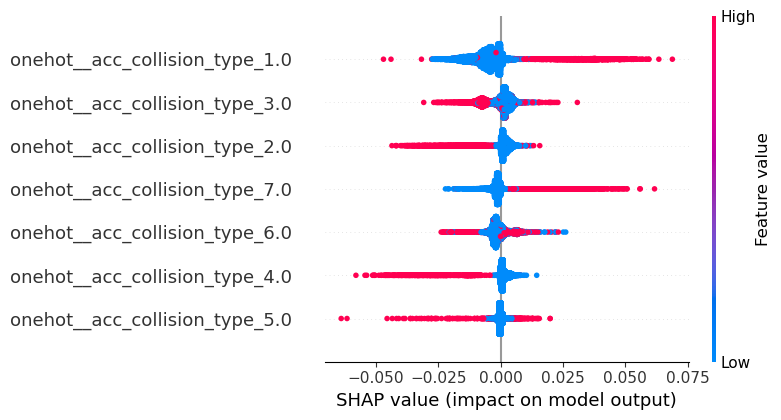

Summary plot for class 3


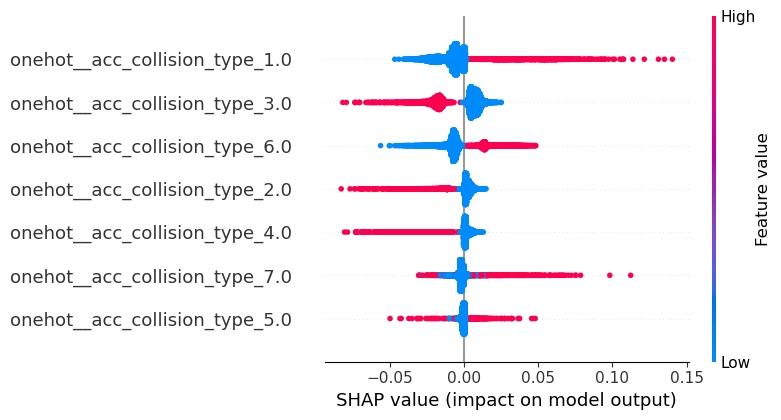

In [39]:
# NEW summary_plot looped over all classes with subset of features
#--------------------------------------------------------------
for c in range(shap_values.values.shape[-1]):  # iterate over classes
    shap_subset = shap_values.values[:, selected_idx, c]
    X_subset = X_sub_df[selected_features]
    print(f"Summary plot for class {c}")
    shap.summary_plot(
        shap_subset,
        features=X_subset,
        feature_names=selected_features,
        max_display=len(selected_features)
    )

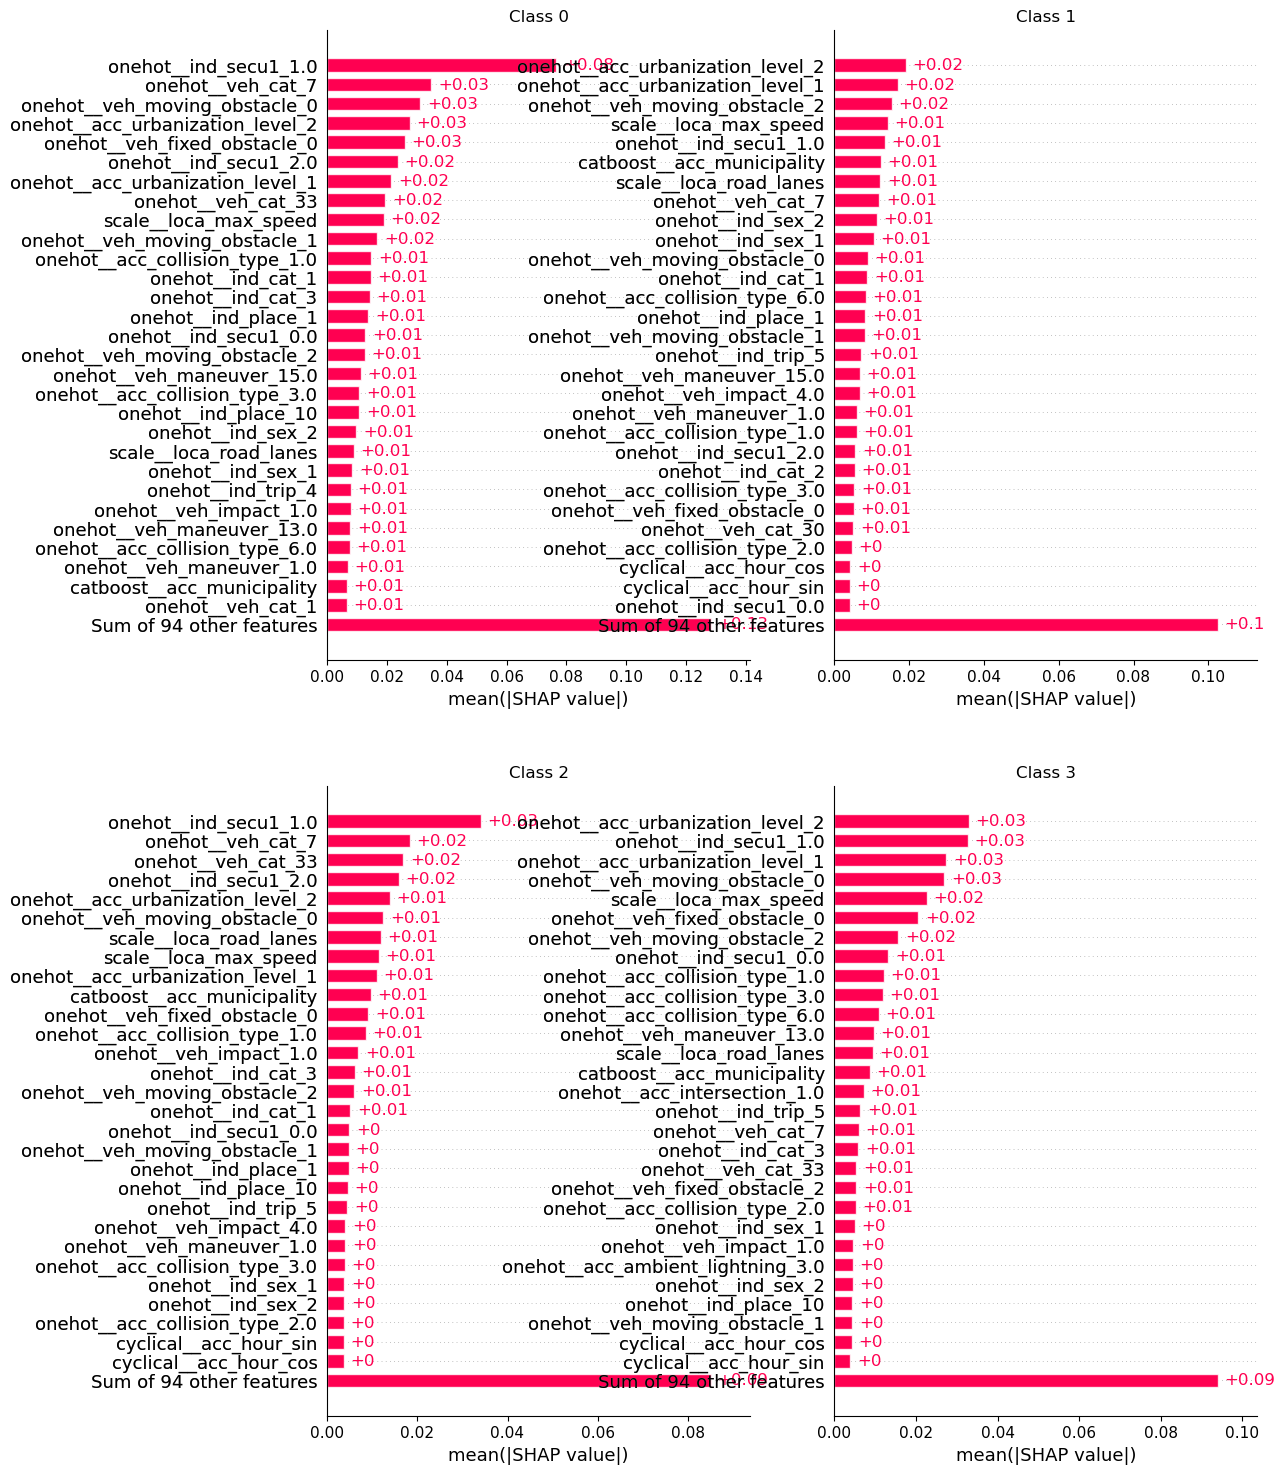

In [40]:
# NEW bar plot per class
#--------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 18))
axes = axes.flatten()

for c in range(shap_values.values.shape[-1]):
    shap.plots.bar(shap_values[:, :, c], max_display=30, show=False, ax=axes[c])
    axes[c].set_title(f"Class {c}")

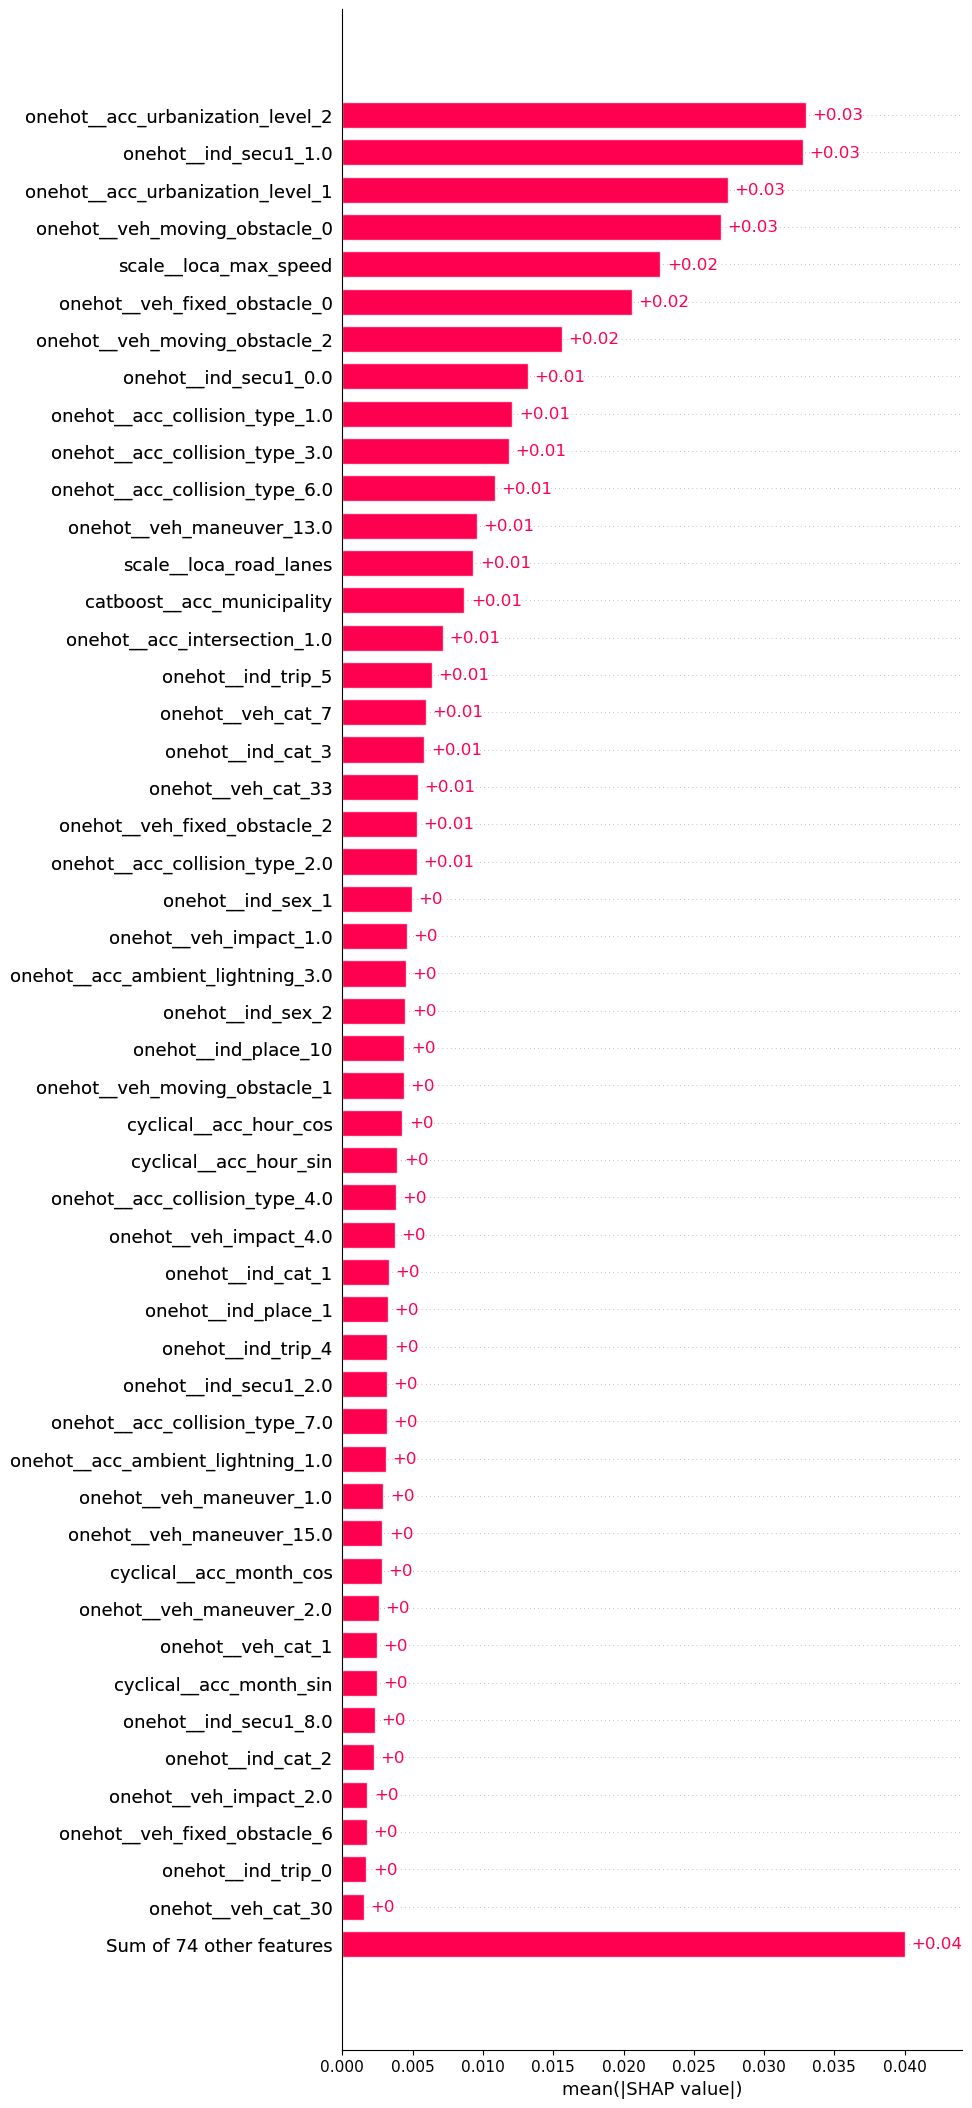

In [41]:
# NEW bar plot for single class
#--------------------------------------------------------------
# use indices for classes: 0,1,2,3
shap.plots.bar(shap_values[:, :, 3], max_display=50)


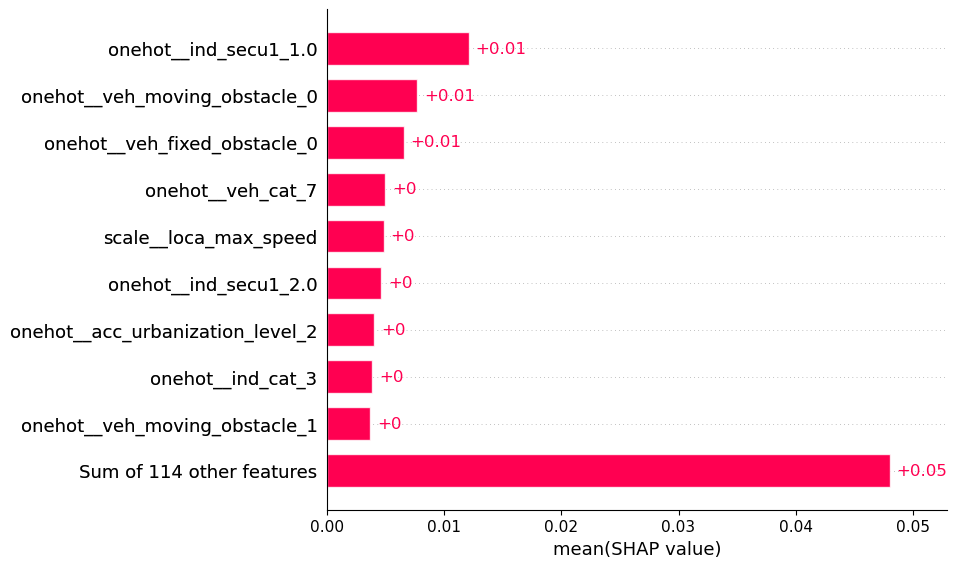

In [24]:
# NEW SHAP: bar plot for single class with mean impact 
#--------------------------------------------------------------
shap.plots.bar(shap_values[:, :, 0].mean(0))

In [48]:
# NEW check architecture of SHAP values
#--------------------------------------------------------------
print(type(shap_values), end="\n\n")          # shap._explanation.Explanation
print(shap_values.shape, end="\n\n")          # (n_samples, n_classes, n_features) for multiclass
print(shap_values.values.shape, end="\n\n")   # same as above, the raw SHAP values
print(shap_values.base_values, end="\n\n")    # expected value(s) for each output
print(shap_values.data, end="\n\n")           # the input data (X_sub_clean) used
print(shap_values.feature_names, end="\n\n")  # feature names if you passed a DataFrame

<class 'shap._explanation.Explanation'>

(9989, 123, 4)

(9989, 123, 4)

[[0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]
 ...
 [0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]]

[[ 8.66025404e-01  5.00000000e-01 -5.00000000e-01 ...  1.83429504e+00
   2.50000000e-01  5.00000000e-01]
 [ 7.07106781e-01 -7.07106781e-01 -5.00000000e-01 ...  1.78583935e+00
   3.33333333e-01  2.77777778e-01]
 [-1.00000000e+00 -1.83697020e-16 -5.00000000e-01 ...  1.80417423e+00
   1.66666667e-01  2.77777778e-01]
 ...
 [-9.65925826e-01 -2.58819045e-01 -5.00000000e-01 ...  1.81329121e+00
   1.66666667e-01  3.88888889e-01]
 [-8.66025404e-01 -5.00000000e-01 -8.66025404e-01 ...  1.75950004e+00
   8.33333333e-02  2.77777778e-01]
 [ 7.07106781e-01 -7.07106781e-01 -5.00000000e-01 ...  1.75975127e+00
   6.66666667e-01  2.77777778e-01]]

[